### Tutorial 9

Modified _E.coli_ can be used to produce succinic acid without forming any by-products. The modified metabolism is given below.

<img src="homosucc.png" width="550" />

Note that the pathway to acetic acid is not present since the gene coding for the required enzyme was removed. Also note that the PEP carboxykinase enzyme (found natively in _A. succinogenes_ from tut 2) was added to the  organism by inserting the relevant gene.

The flux model is supplied, but make sure you can set it up yourself (this might take some time so you can do it after performing the integration part of the problem). Like before the flux model is supplied in a hidden format. Ten equations are supplied in [Tut9eq.xlsx](https://github.com/willienicol/Biochemical-engineering-notes/blob/master/Tutorials/Tut9eq.xlsx), with equation 10 representing the energy balance. All equations are equal to zero except the energy balance that is equal to $\theta$. All rates correspond to the flux numbers on the map with $r_{11}$ representing $CO_2$

It is easy to transfer the 12x10 matrix into Python and add specification equations. You can use the code below. Ensure that the Excel file is in the same directory as the Jupyter notebook file.

The code below generates the matrix for anaerobic conditions where $r_O$ is specified as zero, while $r_X=\mu$ is specified as basis.


In [2]:
from __future__ import division
from numpy import matrix, linalg, linspace, interp, asarray, argmax
import numpy
import pandas
from scipy.integrate import odeint
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
import pandas, numpy

M = numpy.matrix(pandas.read_excel('Tut9eq.xlsx'))
M1 = numpy.vstack([M,[0,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0]])
#print (M1)

The physiological parameters can be taken as:

|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$
|----|-|-|-|-
|$\frac{\text{cmol $CO_2$}}{\text{cmol X}}$|$\frac{\text{mol ATP}}{\text{cmol X}}$|$\frac{1}{\text{h}}$|$\frac{\text{mol ATP}}{\text{cmol X}\cdot \text{h}}$
|0.1|2.2|0.3|0.08

The inhibition functions are given by:

$$\mu(C_S,C_P)= \mu_{max} \left[\frac{Cs}{K_m^{\mu}+Cs} \right]   \left[ 1-\frac{C_P}{{C_P^{*}}^{\mu}} \right] $$

$$\theta(C_S,C_P)= \theta_{max} \left[\frac{Cs}{K_m^{\theta}+Cs} \right]   $$

$C_{P^{*}}^{\mu}$ refers to the terminal succinic acid concentration of $0.75$ $\frac{\text{cmol}}{\text{L}}$. All Monod constants can be taken as $4 \times 10^{-4}$ $\frac{\text{cmol}}{\text{L}}$.

The following initial conditions. $C_X^0=0.002 \frac{cmol}{L}$ and $C_S^0=\frac{100}{30} \frac{cmol}{L}$

In [4]:
alpha = 0.1
gamma = 2.2
mu_max, theta_max = 0.3, 0.08
Km_mu, Km_theta = 4e-4, 4e-4
Cp_star = 0.75

In [5]:
def response_fun(C):
    Cx, Cs, Csa, Cc = C[0], C[1], C[2], C[3] #X S SA C - C is added for question f)
    Cp = Csa
    
    mu1 = mu_max*(Cs/(Km_mu+Cs))*(1-(Cp/Cp_star))
    theta = theta_max*(Cs/(Km_theta+Cs))
    
    if mu1 < 0.0001:
        mu=0
    else:
        mu=mu1
    
    #M1
    K = matrix([[0,0,0,0,0,0,0,0,0,theta,mu,0]]).T
    r = linalg.solve(M1,K)
    
    rx, rs, rsa, rc = r[1,0], -r[0,0], r[9,0], r[11,0]
    
    return [rx,
            rs,
            rsa,
            rc]


In [6]:
def ferm_eq(C,t):
    Cx, Cs, Csa, Cc = C[0], C[1], C[2], C[3] #X S SA CarbonD
    r = response_fun([Cx, Cs, Csa, Cc])
    
    rx, rs, rsa, rc = r[0], r[1], r[2], r[3]
    
    return [rx*Cx,
            rs*Cx,
            rsa*Cx,
            rc*Cx]

In [7]:
Co = [0.002,100/30,0,0] # X S SA
tspan = linspace(0,200,300)

Ci = odeint(ferm_eq, Co, tspan)

Cx = Ci[:,0]
Cs = Ci[:,1]
Csa = Ci[:,2]
Cc = Ci[:,3]

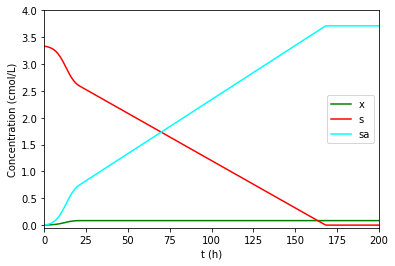

In [8]:
plt.figure(1)
plt.plot(tspan, Cx, color = 'green', label = 'x')
plt.plot(tspan, Cs, color = 'red', label = 's')
plt.plot(tspan, Csa, color = 'cyan', label = 'sa')
plt.axis([0,200,-0.05,4])
plt.xlabel('t (h)')
plt.ylabel('Concentration (cmol/L)')
plt.legend(loc='best')
#plt.grid()
plt.show()

a) How long will the fermentation take? 

In [9]:
#the fermentation process proceeds untill gluc is fully consumed - i.e when Cs = 0

t_nogluc = interp(0,Cs[::-1],tspan[::-1])
print ('the fermentation process will take ', t_nogluc, 'hours')


the fermentation process will take  168.56187283839085 hours


b) Determine the instantaneous **volumetric** rate of succinic acid production and $Y_{SSA}$ at 10 hours. [$1.5 \frac{g}{L\cdot h}$, $0.97 \frac{g}{g}$]

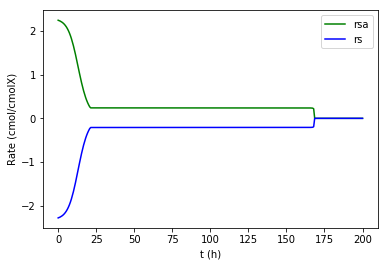

In [10]:
r = asarray([response_fun(C) for C in Ci])
rs = r[:,1]
rsa = r[:,2]
rc = r[:,3]

plt.figure(2)
plt.plot(tspan, rsa, color = 'green', label = 'rsa')
plt.plot(tspan, rs, color = 'blue', label = 'rs')
#plt.axis([0,200,-0.05, 2.5])
plt.xlabel('t (h)')
plt.ylabel('Rate (cmol/cmolX)')
plt.legend(loc='best')
#plt.grid()
plt.show()

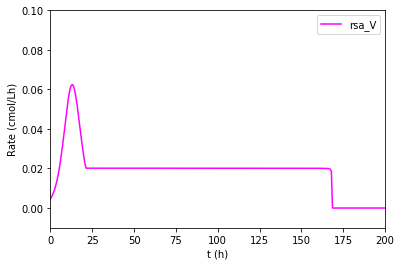

In [11]:
rsa_V = rsa*Cx

plt.figure(3)
plt.plot(tspan, rsa_V, color = 'magenta', label = 'rsa_V')
plt.axis([0,200,-0.01, 0.1])
plt.xlabel('t (h)')
plt.ylabel('Rate (cmol/Lh)')
plt.legend(loc='best')
#plt.grid()
plt.show()

In [12]:
findrsa_V = interp(10,tspan,rsa_V)
#print ('at t = 10 hours, rsa_V = ', findrsa_V, 'cmolSA/Lh')
print ('at t = 10 hours, rsa_V = ', findrsa_V*29.5, 'gSA/Lh')
print ('  ')

findrs = interp(10,tspan,rs)
findrsa = interp(10,tspan,rsa)
print ('at t = 10 hours, Yssa = ', (findrsa/-findrs)*(29.5/30), 'gSA/gS')
print ('  ')

at t = 10 hours, rsa_V =  1.4960528336085128 gSA/Lh
  
at t = 10 hours, Yssa =  0.9744037917988729 gSA/gS
  


c) Determine the instantaneous **volumetric** rate of succinic acid production and $Y_{SSA}$ at 60 hours and comment. [$0.665 \frac{g}{L \cdot h}$ and $1.09 \frac{g}{g}$]

In [13]:
findrsa_V = interp(60,tspan,rsa_V)
#print ('at t = 60 hours, rsa_V = ', findrsa_V, 'cmolSA/Lh')
print ('at t = 60 hours, rsa_V = ', findrsa_V*29.5, 'gSA/Lh')
print ('  ')

findrs = interp(60,tspan,rs)
findrsa = interp(60,tspan,rsa)
print ('at t = 60 hours, Yssa = ', (findrsa/-findrs)*(29.5/30), 'gSA/gS')
print ('  ')

at t = 60 hours, rsa_V =  0.594782810087778 gSA/Lh
  
at t = 60 hours, Yssa =  1.1238095238095123 gSA/gS
  


d) At what time is the maximum value of $r_{SA}^V$ obtained? [$13 h$]

In [14]:
rsa_Vmaxindex = argmax(rsa_V == max(rsa_V))
#rsa_Vmax = rsa_V[rsa_Vmaxindex]
tmax = tspan[rsa_Vmaxindex]

print ('rsa_V is max at t = ', tmax, 'hours')

rsa_V is max at t =  13.377926421404682 hours


e) What is the APY and productivity of the fermentation above? 

In [15]:
tdone = interp(0.0001,Cs[::-1],tspan[::-1]) 
P=max(Csa)/tdone*29.5
Y=max(Csa)/(100/30)*29.5/30
[P, Y]



[0.6495394834999145, 1.0947721408349684]

f) What is the volumetric rate of $CO_2$ consumption at 60 hours? [$2.5 \frac{mmol}{L\cdot h} $]  

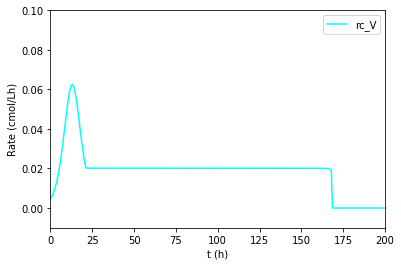

In [16]:
rc_V = rc*Cx

plt.figure(4)
plt.plot(tspan, rsa_V, color = 'cyan', label = 'rc_V')
plt.axis([0,200,-0.01, 0.1])
plt.xlabel('t (h)')
plt.ylabel('Rate (cmol/Lh)')
plt.legend(loc='best')
#plt.grid()
plt.show()

In [17]:
findrc_V = interp(60,tspan,rc_V)
#print ('at t = 60 hours, rc_V = ', findrc_V*(-1000), 'mmolC/Lh')
print ('at t = 60 hours, rc_V = ', -findrc_V*1000, 'mmolC/Lh')
print ('  ')

at t = 60 hours, rc_V =  2.5202661444397347 mmolC/Lh
  


g) How will a higher product titre ($C_{SA}^{final}$) be achieved? Will the APY and productivity be higher or lower for this fermentation.

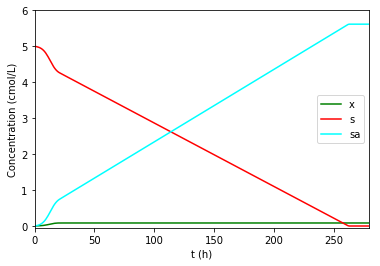

In [18]:
def response_fun1(C):
    Cx, Cs, Csa, Cc = C[0], C[1], C[2], C[3] #X S SA C - C is added for question f)
    Cp = Csa
    
    mu1 = mu_max*(Cs/(Km_mu+Cs))*(1-(Cp/Cp_star))
    theta = theta_max*(Cs/(Km_theta+Cs))
    
    if mu1 < 0.0001:
        mu=0
    else:
        mu=mu1
    
    #M1
    K = matrix([[0,0,0,0,0,0,0,0,0,theta,mu,0]]).T
    r = linalg.solve(M1,K)
    
    rx, rs, rsa, rc = r[1,0], -r[0,0], r[9,0], r[11,0]
    
    return [rx,
            rs,
            rsa,
            rc]


def ferm_eq1(C,t):
    Cx, Cs, Csa, Cc = C[0], C[1], C[2], C[3] #X S SA CarbonD
    r = response_fun([Cx, Cs, Csa, Cc])
    
    rx, rs, rsa, rc = r[0], r[1], r[2], r[3]
    
    return [rx*Cx,
            rs*Cx,
            rsa*Cx,
            rc*Cx]


Co1 = [0.002,150/30,0,0] # X S SA
tspan1 = linspace(0,280,300)

Ci1 = odeint(ferm_eq1, Co1, tspan1)

Cx = Ci1[:,0]
Cs = Ci1[:,1]
Csa = Ci1[:,2]
Cc = Ci1[:,3]



plt.figure(5)
plt.plot(tspan1, Cx, color = 'green', label = 'x')
plt.plot(tspan1, Cs, color = 'red', label = 's')
plt.plot(tspan1, Csa, color = 'cyan', label = 'sa')
plt.axis([0,280,-0.05,6])
plt.xlabel('t (h)')
plt.ylabel('Concentration (cmol/L)')
plt.legend(loc='best')
#plt.grid()
plt.show()

In [19]:
#the fermentation process proceeds untill gluc is fully consumed - i.e when Cs = 0

t_nogluc1 = interp(0,Cs[::-1],tspan1[::-1])
print ('the fermentation process will take ', t_nogluc1, 'hours')

the fermentation process will take  263.14381269627 hours


In [20]:
tdone1 = interp(0.0001,Cs[::-1],tspan1[::-1]) 
P=max(Csa)/tdone1*29.5
Y=max(Csa)/(150/30)*29.5/30
[P, Y]

[0.6296047581156515, 1.1044512680846235]

Continuation of tut 9b below

h) It is also possible to operate the fermentation under aerobic conditions. Zero succinic acid will form when sufficient oxygen is available (assume this to be the case). Operate the fermenter aerobically for 15 hours by sparging with oxygen and then switch to sparging with $CO_2$. Note that the specifications in the response matrix will alter between aerobic and anaerobic conditions. Integrate the aerobic and anaerobic sections separately, but plot together on a single graph. Determine the APY and productivity of the total fermentation. Compare to the answer in (e) and explain to yourself. What happened to $C_{SA}^{final}$ when comparing to (e)? Also play with increasing the aerobic fermentation time. Take enough time in understanding the concentration profiles and don't just focus on getting the answers. 

[$1.64 \frac{g}{L \cdot h}$ and $0.99 \frac{g}{g}$]

In [21]:
#part 2 - for aerobic conditions (from t=0 -> t=15)

S = matrix(pandas.read_excel('Tut9eq.xlsx'))
S2 = numpy.vstack([S,[0,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0]]) ### this part changed

def response_fun2(C):
    Cx, Cs, Csa, Cc, CO = C[0], C[1], C[2], C[3], C[4] #X S SA C O2
    Cp = Csa
    
    mu1 = mu_max*(Cs/(Km_mu+Cs))*(1-(Cp/Cp_star))
    theta = theta_max*(Cs/(Km_theta+Cs))
    
    if mu1 < 0.0001:
        mu=0
    else:
        mu=mu1
    
    #S2
    c = matrix([[0,0,0,0,0,0,0,0,0,theta,mu,0]]).T
    r2 = linalg.solve(S2,c)
    
    rx2, rs2, rsa2, rc2, rO2 = r2[1,0], -r2[0,0], r2[9,0], r2[11,0], r2[10,0]
    
    return [rx2,
            rs2,
            rsa2,
            rc2,
            rO2]

def ferm_eq2(C,t):
    Cx2, Cs2, Csa2, Cc2, CO2 = C[0], C[1], C[2], C[3], C[4] #X S SA
    r2 = response_fun2([Cx2, Cs2, Csa2, Cc2, CO2])
    
    rx2, rs2, rsa2, rc2, rO2 = r2[0], r2[1], r2[2], r2[3], r2[4]
    
    return [rx2*Cx2,
            rs2*Cx2,
            rsa2*Cx2,
            rc2*Cx2,
            rO2*Cx2]

Co2 = [0.002,100/30,0,0,0] # X S SA -- initial O2 = 0?
tspan2 = linspace(0,15,1000)

Ci2 = odeint(ferm_eq2, Co2, tspan2)

Cx2 = Ci2[:,0]
Cs2 = Ci2[:,1]
Csa2 = Ci2[:,2]
Cc2 = Ci2[:,3]
CO2 = Ci2[:,4]

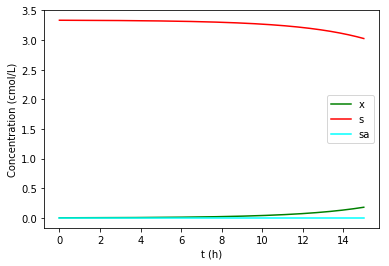

In [22]:
plt.figure(6)
plt.plot(tspan2, Cx2, color = 'green', label = 'x')
plt.plot(tspan2, Cs2, color = 'red', label = 's')
plt.plot(tspan2, Csa2, color = 'cyan', label = 'sa')
#plt.plot(tspan2, Cc2, color = 'magenta', label = 'CO2')
#plt.plot(tspan2, CO2, color = 'blue', label = 'O2')
#plt.axis([0,200,-0.05,4])
plt.xlabel('t (h)')
plt.ylabel('Concentration (cmol/L)')
plt.legend(loc='best')
#plt.grid()
plt.show()

In [23]:
Cx15 = Cx2[-1]
Cs15 = Cs2[-1]
Csa15 = Csa2[-1]
Cc15 = Cc2[-1]
CO15 = CO2[-1]


print ('Cx15 = ', Cx15)
print ('Cs15 = ', Cs15)
print ('Csa15 = ', Csa15)
print ('Cc15 = ', Cc15)
print ('CO15 = ', CO15)


Cx15 =  0.17993634639047837
Cs15 =  3.0251799334480025
Csa15 =  0.0
Cc15 =  0.13021705349485002
CO15 =  0.12132023617532614


In [24]:
#part 1 - for aerobic conditions (from t=15 -> t=100)

S = matrix(pandas.read_excel('Tut9eq.xlsx'))
S1 = numpy.vstack([S,[0,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0]])

def response_fun1(C):
    Cx1, Cs1, Csa1, Cc1 = C[0], C[1], C[2], C[3] #X S SA C 
    Cp = Csa
    
    mu1 = mu_max*(Cs/(Km_mu+Cs))*(1-(Cp/Cp_star))
    theta = theta_max*(Cs/(Km_theta+Cs))
    
    if mu1 < 0.0001:
        mu=0
    else:
        mu=mu1
    
    #S1
    c = matrix([[0,0,0,0,0,0,0,0,0,theta,mu,0]]).T
    r1 = linalg.solve(S1,c)
    
    rx1, rs1, rsa1, rc1 = r1[1,0], -r1[0,0], r1[9,0], r1[11,0]
    
    return [rx1,
            rs1,
            rsa1,
            rc1]

def ferm_eq1(C,t):
    Cx1, Cs1, Csa1, Cc1 = C[0], C[1], C[2], C[3] #X S SA
    r1 = response_fun([Cx1, Cs1, Csa1, Cc1])
    
    rx1, rs1, rsa1, rc1 = r1[0], r1[1], r1[2], r1[3]
    
    return [rx1*Cx1,
            rs1*Cx1,
            rsa1*Cx1,
            rc1*Cx1]

Co1 = [Cx2[-1], Cs2[-1], Csa2[-1], CO2[-1]] # X S SA O  ##############
tspan1 = linspace(15,75,1000)         ##############

Ci1 = odeint(ferm_eq1, Co1, tspan1)

Cx1 = Ci1[:,0]
Cs1 = Ci1[:,1]
Csa1 = Ci1[:,2]
Cc1 = Ci1[:,3]

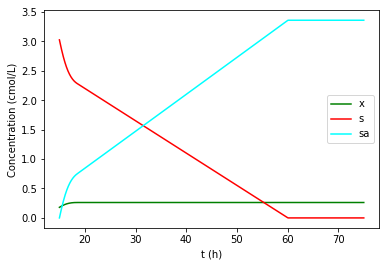

In [25]:
plt.figure(7)
plt.plot(tspan1, Cx1, color = 'green', label = 'x')
plt.plot(tspan1, Cs1, color = 'red', label = 's')
plt.plot(tspan1, Csa1, color = 'cyan', label = 'sa')
#plt.axis([0,200,-0.05,4])
plt.xlabel('t (h)')
plt.ylabel('Concentration (cmol/L)')
plt.legend(loc='best')
#plt.grid()
plt.show()

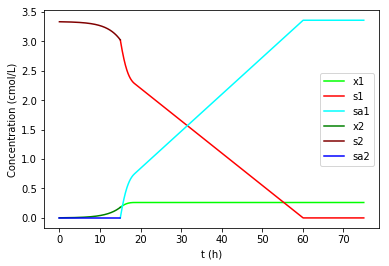

In [26]:
plt.figure(8)
plt.plot(tspan1, Cx1, color = 'lime', label = 'x1')
plt.plot(tspan1, Cs1, color = 'red', label = 's1')
plt.plot(tspan1, Csa1, color = 'cyan', label = 'sa1')

plt.plot(tspan2, Cx2, color = 'green', label = 'x2')
plt.plot(tspan2, Cs2, color = 'maroon', label = 's2')
plt.plot(tspan2, Csa2, color = 'blue', label = 'sa2')
#plt.axis([0,200,-0.05,4])
plt.xlabel('t (h)')
plt.ylabel('Concentration (cmol/L)')
plt.legend(loc='best')
#plt.grid()
plt.show()

In [27]:
APY = (Csa1[-1]-Csa2[0])/-(Cs1[-1]-Cs2[0])
print (APY*(29.5/30))

0.9908804187323036


In [28]:
#t_noglucf2 = 15
t_noglucf1 = interp(0,Cs1[::-1],tspan1[::-1])
#t_noglucf = t_noglucf2 + t_noglucf1 
#print (t_noglucf1)

DeltaCsa = Csa1[-1]-Csa2[0]
productivity = (DeltaCsa*29.5)/t_noglucf1
print ('productivity = ', productivity, 'g/L.h')


productivity =  1.6454898550142443 g/L.h


i) It should be clear that $CO_2$ is consumed when operating under anaerobic conditions. What will happen when the $CO_2$ supply in this phase is shut off? For the aerobic phase oxygen sparging is required, but is it in order to shut off the $CO_2$ supply? Determine the $CO_2$ consumption/production at the start of the aerobic phase in (h). Also investigate the internal flux distribution in the aerobic phase by having a close look at fluxes $r_4$ and $r_5$. What is the difference between the simplified respiration model in [section 4.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/4%20Stoichiometry%20that%20includes%20internal%20reactions/TCA%20cycle%20and%20oxidative%20phosphorylation.ipynb) and the respiration in this tutorial?

j) What is the difference between $-r_{S}$ at the end of the aerobic phase and the start of the anaerobic phase? Why the difference? [$\frac {-r_S^{anaer}}{-r_S^{aer}} = 4.4$}

k) Plot the volumetric consumption rate of oxygen ($r_{O_2}^V$) as a function of time for the aerobic phase. If the oxygen supply to the fermenter had a maximum possible value of $0.02 \frac{\text{mol }O_2}{\text{L}\cdot \text{h}}$, how will the organism respond to the limitation?

l) Perform your own flux model (set up your own response function). Include $CO_2$ as seperate flux. Check against the supplied model. Note the following stoichiometric relationship: $r_6=2r_3$ ($C_4$ joining $C_2$ to form $C_6$). Use the standard elemental composition for biomass. 

m) If the PEP carboxykinase gene is removed and replaced with the more conventional pyruvate carboxylase, the ATP balance of the organism will be affected. Note that a mole of ATP is required to convert pyruvate to oxaloacetate via pyruvate carboxylase. Determine how the biomass yield on glucose will be affected when the modification is performed (assume zero inhibition). How will this modification affect the anaerobic fermentation? How will the modification affect the aerobic-anaerobic combo fermentation?[$\frac{Y_{SX}^{xylase}}{Y_{SX}^{kinase}}=0.28$]